In [ ]:
# %cd ..

In [1]:
# type: ignore

import typing
from typing import Any, cast, Literal
from dataclasses import dataclass
from itertools import pairwise

import gigaam
from gigaam.model import GigaAMASR
import jiwer
from datasets import Dataset, load_dataset, Audio
import numpy as np
import numpy.typing as npt
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from asr_eval.data import Recording
from asr_eval.align.data import Match, Token
from asr_eval.models.gigaam import EncodeError
from asr_eval.streaming.sender import StreamingAudioSender, BaseStreamingAudioSender
from asr_eval.streaming.caller import receive_full_transcription
from asr_eval.streaming.models.vosk import VoskStreaming
from asr_eval.streaming.model import StreamingASR, TranscriptionChunk, InputChunk, OutputChunk, Signal
from asr_eval.streaming.evaluation import RecordingStreamingEvaluation, PartialAlignment, get_partial_alignments, remap_time
from asr_eval.streaming.plots import partial_alignment_diagram, visualize_history
from asr_eval.streaming.timings import get_word_timings
from asr_eval.serializing import save_to_json, load_from_json
from asr_eval.utils import N

In [2]:
gigaam_model = typing.cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))

In [3]:
# type: ignore

name, split = 'bond005/podlodka_speech', 'test'
dataset: Dataset = (
    load_dataset(name)[split]
    .cast_column("audio", Audio(sampling_rate=16_000))
)

samples: list[Recording] = []

for i in tqdm(range(len(dataset))):
    try:
        samples.append(Recording.from_sample(
            sample=dataset[i],
            name=name,
            split=split,
            index=i,
            use_gigaam=gigaam_model,
        ))
    except EncodeError:
        pass
    break

  0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
def default_evaluation_pipeline(
    recording: Recording,
    asr: StreamingASR,
) -> RecordingStreamingEvaluation:
    assert recording.waveform is not None

    evals = RecordingStreamingEvaluation()
    evals.id = recording.hf_uid

    # preparing input audio
    match asr.audio_type:
        case 'float':
            audio = recording.waveform
            array_len_per_sec = asr.sampling_rate
        case 'int':
            audio = (recording.waveform * 32768).astype(np.int16)
            array_len_per_sec = asr.sampling_rate
        case 'bytes':
            audio = (recording.waveform * 32768).astype(np.int16).tobytes()
            array_len_per_sec = asr.sampling_rate * 2  # x2 because of the conversion int16 -> bytes
    
    # predicting
    evals.sender = StreamingAudioSender(
        id=evals.id,
        audio=audio,
        array_len_per_sec=array_len_per_sec,
        real_time_interval_sec=1 / 5,
        speed_multiplier=1,
        verbose=False,
    )
    output_chunks = receive_full_transcription(
        asr=asr,
        sender=evals.sender,
        id=evals.id,
        send_all_without_delays=True,
    )

    # processing to save the results
    evals.cutoffs = evals.sender.get_send_times()
    evals.input_chunks, evals.output_chunks = remap_time(
        evals.cutoffs,
        evals.sender.history,
        output_chunks,
    )
    evals.partial_alignments = get_partial_alignments(
        evals.input_chunks,
        evals.output_chunks,
        cast(list[Token], recording.transcription_words),
        processes=1,
        timestamps=np.arange(
            evals.start_timestamp,
            evals.finish_timestamp + 0.2 - 0.0001,
            step=0.2,
        ).tolist(),
    )

    # partial_alignment_diagram(
    #     evals.partial_alignments,
    #     cast(list[Token], recording.transcription_words),
    #     audio_len=cast(float, evals.input_chunks[-1].end_time),  # TODO: may be not precise
    #     figsize=(12, 2),
    #     y_type='processed',
    # )

    # cleaning large arrays to save the results
    evals.sender.audio = ''
    evals.sender.history = []
    for input_chunk in evals.input_chunks:
        if input_chunk.data != Signal.FINISH:
            input_chunk.data = ''
        
    return evals


asr = VoskStreaming(model_name='vosk-model-ru-0.42', chunk_length_sec=1)
asr.start_thread()
for recording in tqdm(samples):
    recording.evals = default_evaluation_pipeline(recording, asr)
    recording.waveform = None
asr.stop_thread()

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/oleg/.cache/vosk/vosk-model-ru-0.42/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:297) Loading words from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:30

  0%|          | 0/1 [00:00<?, ?it/s]

Transcribing bond005/podlodka_speech/test/0
Transcribed bond005/podlodka_speech/test/0: и поэтому использовать их в повседневности не получается мы вынуждены отступать


In [5]:
save_to_json(samples, 'samples.json')

In [6]:
samples: list[Recording] = load_from_json('samples.json')

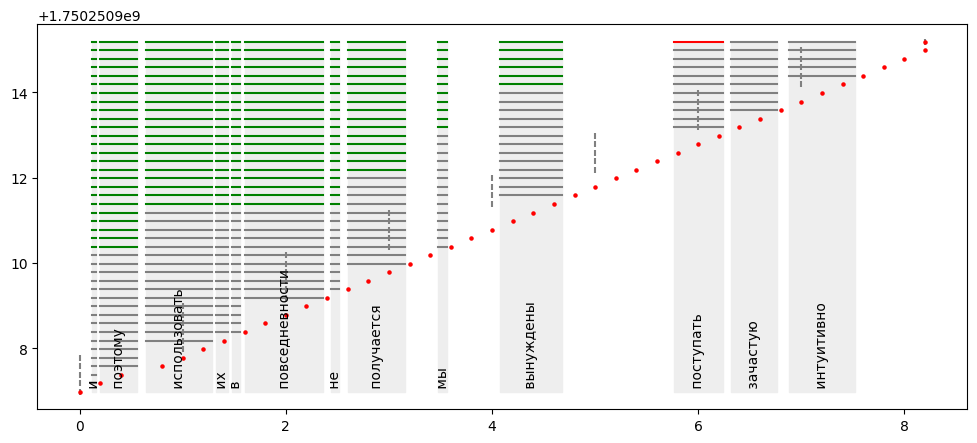

In [7]:
recording = samples[0]

partial_alignment_diagram(
    N(N(recording.evals).partial_alignments),
    cast(list[Token], recording.transcription_words),
    start_real_time=N(N(N(recording.evals).input_chunks)[0].put_timestamp),
    end_real_time=N(N(N(recording.evals).output_chunks)[-1].put_timestamp),
    figsize=(12, 5),
)

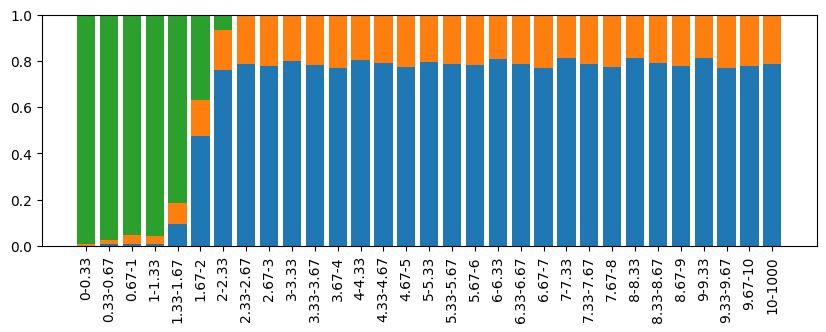

In [ ]:
error_positions = sum([
    partial_alignment.get_error_positions()
    for recording in samples
    for partial_alignment in recording.evals.partial_alignments # type: ignore
], [])

counts: dict[Literal['correct', 'error', 'not_yet'], npt.NDArray[np.int64]] = {}

# bins = [0, 1, 2, 3, 5, 10, 1000]
bins = np.linspace(0, 10, num=31).round(2).tolist() + [1000]
for status in 'correct', 'error', 'not_yet':
    counts[status] = np.histogram([x.time_delta for x in error_positions if x.status == status], bins=bins)[0]

total_counts = sum(counts.values())

ratios = {status: c / total_counts for status, c in counts.items()}

plt.figure(figsize=(10, 3)) # type: ignore
xrange = range(len(bins) - 1)
plt.bar(xrange, height=ratios['correct']) # type: ignore
plt.bar(xrange, height=ratios['error'], bottom=ratios['correct']) # type: ignore
plt.bar(xrange, height=ratios['not_yet'], bottom=ratios['correct'] + ratios['error']) # type: ignore
plt.gca().set_xticks(xrange) # type: ignore
plt.gca().set_xticklabels([f'{a:g}-{b:g}' for a, b in pairwise(bins)], rotation=90) # type: ignore
plt.show() # type: ignore